In [50]:
import numpy as np
import argparse
import time
# The mnist library is from https://gist.github.com/akesling/5358964 and provides functions to 
# read MNIST into numpy arrays for processing.
from mnist import read, show

In [51]:
# read array of tuples of arrays
training_data_orig = list(read(dataset='training', path='.'))

./train-images-idx3-ubyte


In [52]:
# reads and binarizes 500 images
training_data = training_data_orig[:500]
labels, imgs = zip(*training_data)
training_binarized = (np.array(imgs)/255 > 0.5).astype(int)
training_binarized = training_binarized*2 - 1

In [53]:
# introduces 2% noise into each binarized image
training_noisy = np.copy(training_binarized)
# flip 16 values in each image
for i in range(len(training_binarized)):
    for count in range(16):
        row = np.random.randint(0,28)
        col = np.random.randint(0,28)
        training_noisy[i][row][col] = -1 * training_binarized[i][row][col]

In [54]:
theta_hi_xj = 2
theta_hi_hj = 0.2
def boltzmann(img, c):
    res = np.random.rand(28,28)
    for a in range(20):
        for i in range(len(img)):
            for j in range(len(img[0])):

                inner = 0
                if j > 0:
                    inner += c*(2*res[i][j-1] - 1) + theta_hi_xj*img[i][j-1]

                if j < len(img[0])-1:
                    inner += c*(2*res[i][j+1] - 1) + theta_hi_xj*img[i][j+1]

                if i > 0:
                    inner += c*(2*res[i-1][j] - 1) + theta_hi_xj*img[i-1][j]

                if i < len(img)-1:
                    inner += c*(2*res[i+1][j] - 1) + theta_hi_xj*img[i+1][j]
#                 print(inner)
                res[i][j] = np.exp(inner) / (np.exp(-1*inner) + np.exp(inner))

    return res # table of pi probabilities

In [55]:
def boltzmann_parallel(imgs,c):
    result = np.empty(np.shape(training_noisy))
    for i in range(len(result)):
        print(i)
        result[i] = boltzmann(imgs[i], c)
    return result

In [56]:
training_denoised = np.empty(np.shape(training_noisy)) # for c = 0.2 case

In [57]:
# denoise all 500 images in parallel
from multiprocessing import Process, Pool
pool = Pool(7)
results_array = pool.starmap(boltzmann_parallel, [(training_binarized, -1),(training_binarized, -0.6),(training_binarized, -0.2),(training_binarized, 0),(training_binarized, 0.2),(training_binarized, 0.6),(training_binarized, 1)])
# results array = denoised images with values of c= -1, -0.6, -0.2, 0, 0.2(default), 0.6, 1


0
0
0
0
0
0
0
1
1
1
1
1
1
1
2
2
2
2
2
2
2
3
3
3
3
3
3
3
4
4
4
4
4
4
4
5
5
5
5
5
5
5
6
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
8
8
9
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
16
17
18
17
17
18
18
17
18
19
19
18
19
18
19
18
20
20
20
19
19
20
19
21
21
21
21
20
20
20
22
22
22
22
21
21
21
23
23
23
23
22
22
22
24
24
24
24
23
23
23
25
25
25
25
24
24
24
26
26
26
26
25
25
25
27
27
27
27
26
26
26
28
28
28
28
27
27
29
27
29
29
29
28
28
30
30
28
30
30
29
29
31
29
31
31
31
30
30
32
32
32
32
30
31
31
33
33
33
33
31
34
32
32
34
34
34
32
35
35
33
35
33
35
33
36
36
36
34
34
36
34
37
37
37
37
35
35
35
38
38
38
38
36
36
36
39
39
39
39
37
37
37
40
40
40
40
38
38
38
41
41
41
41
39
39
39
42
42
42
42
40
40
40
43
43
43
43
41
41
41
44
44
44
44
42
42
42
45
45
45
45
43
43
46
43
46
46
46
44
44
47
47
44
47
47
45
45
48
48
48
48
45
46
49
46
49
49
49
46
50
47
47
50
50
50
47
51
48
48
51
51
51
48
52
52

In [58]:
# binarize denoised images
training_denoised_bin = np.empty(np.shape(training_noisy)) # for the default c = 0.2 case
results_bin = np.empty(np.shape(results_array))
for n in range(len(results_array)):
    for i in range(len(results_array[n])):
        for row in range(len(results_array[n][i])):
            for col in range(len(results_array[n][i][0])):
                if results_array[n][i][row][col] > 0.5:
                    training_denoised[i][row][col] = 255
                    training_denoised_bin[i][row][col] = 1
                    results_bin[n][i][row][col] = 1
                else:
                    training_denoised[i][row][col] = 0
                    training_denoised_bin[i][row][col] = -1
                    results_bin[n][i][row][col] = -1

In [66]:
# calculates different pixels in all images
fraction = np.sum(np.abs(training_denoised_bin - training_binarized)) / (2 * 500 * (28 ** 2))
print(1 - fraction) # percentage of correct pixels

0.983280612245


In [86]:
recons = np.abs(training_denoised_bin - training_binarized)
zipped = zip(training_denoised_bin, training_binarized, recons, training_noisy)
zipped_s = sorted(zipped, key=lambda x: np.count_nonzero(x[2]))

#### Most accurate reconstruction

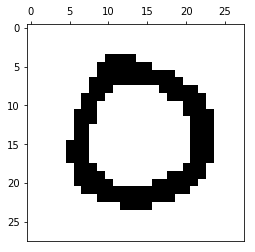

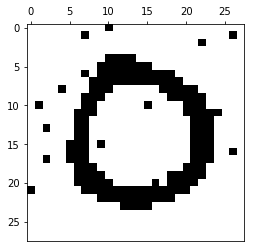

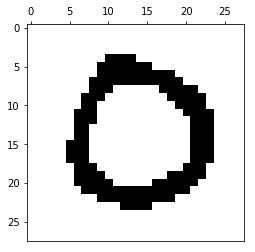

In [87]:
show(zipped_s[0][1]) # most accurate training image
show(zipped_s[0][3]) # most accurate training image, noisy
show(zipped_s[0][0]) # most accurate reconstruction

#### Least accurate reconstruction

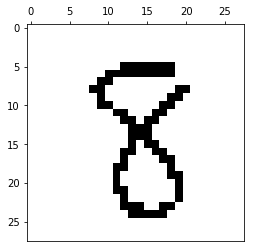

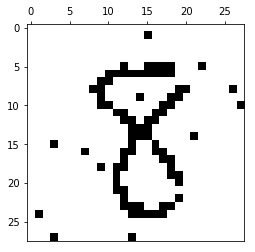

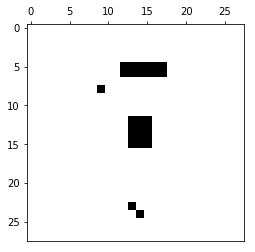

In [92]:
show(zipped_s[-1][1]) # least accurate training image
show(zipped_s[-1][3]) # least accurate training image, noisy
show(zipped_s[-1][0]) # least accurate reconstruction

## Receiver Operating Curves

In [106]:
roc_tpr = []
roc_fpr = []

for n in range(len(results_bin)):
    numCorrect = 0
    numFalse = 0
    numTrueBlack = 0
    numTrueWhite = 0
    for i in range(500):
        for j in range(28):
            for k in range(28):
                if training_binarized[i,j,k] == 1:
                    numTrueBlack += 1
                    if results_bin[n,i,j,k] == 1:
                        numCorrect += 1
                else:
                    numTrueWhite += 1
                    if results_bin[n,i,j,k] == 1:
                        numFalse += 1

    roc_tpr.append(float(numCorrect) / float(numTrueBlack))
    roc_fpr.append(float(numFalse) / float(numTrueWhite))

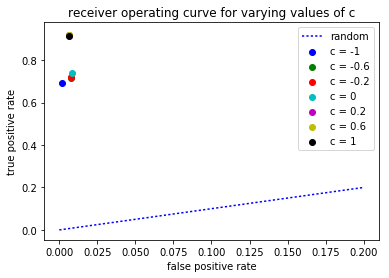

In [163]:
## import matplotlib.pyplot as plt
labels = ['c = -1','c = -0.6','c = -0.2','c = 0','c = 0.2','c = 0.6','c = 1']
colors = ['b','g','r','c','m','y','k']
roc_tpr = [0.6918469551282052,    0.7171474358974359,   0.7200721153846154,  0.7399719551282051,  0.919551282051282,    0.9165064102564102,   0.9125]
roc_fpr = [0.0020053788587464923, 0.007865411599625816, 0.00800572965388213, 0.00807588868101029, 0.006203227315247895, 0.006279232927970065, 0.006390318054256315]
plt.plot([0,.2],[0,.2], color='blue', linestyle='dotted', label='random')
a = []
for i,(x,y) in enumerate(zip(roc_fpr, roc_tpr)):
    a.append(plt.scatter(x,y,color=colors[i], label=labels[i]))

plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve for varying values of c')
plt.show()

### Explanation

The ROC curve, visualized above, compares the false positive rate tothe true positive rate. An ideal ROC curve approaches the top left corner of the chart which represents a perfect true positive rate (100%) and 0% false positive rate. We can see that the points generated using negative and zero values of c have a much lower true positive rate than those using c values greater than 0. The dotted line is a worst-case scenario: that is, it represents the true and false positive rate of picking between black and white pixels randomly. Anything above this line is considered accurate.